<center><img src='./Figs/cs-logo.png' width=200></center>



<h6><center></center></h6>

<h1>
<hr style=" border:none; height:3px;">
<center>Sujet 2 : Mouvement et flot optique </center>
<hr style=" border:none; height:3px;">
</h1>

L'objectif de ce TP est de mettre en oeuvre les techniques classiques d'estimation du mouvement et de suivi dans des images (Source : Stanford CV course).


# TP FINAL REALISE PAR LE BINOME :  
## DEBRAY Clarisse & GLERANT Pierre

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from IPython.display import HTML

# Afficher une séquence d'images

Dans ce Lab, les vidéos sont fournies sous forme de séries temporelles d'images. Elles se trouvent dans le répertoire [images](./images).
Vous avez-ci dessous des fonctions utiles pour charger les images et les visualiser sous la forme d'un court clip vidéo.

Il est possible qu'il vous faille installer un codec vidéo comme [FFmpeg](https://www.ffmpeg.org/). Si vous avez conda (ou Anaconda), vous pouvez généralement l'installer avec `conda install -c conda-forge ffmpeg`. Pour Linux/Mac, vous pourrez aussi installer ffmpeg en utilisant `apt-get` ou `brew`. Pour Windows, vous pouvez trouver les instructions d'installation [ici](https://www.wikihow.com/Install-FFmpeg-on-Windows).


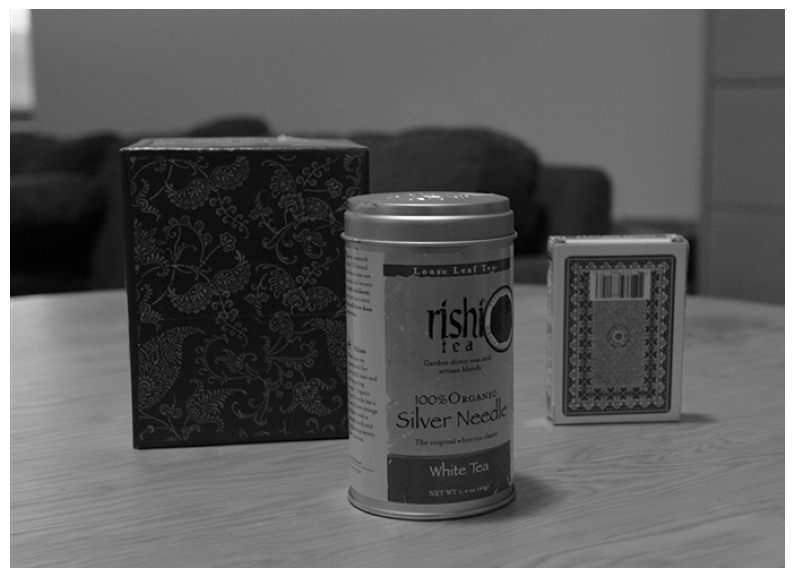

In [2]:
import os
import cv2
from matplotlib import animation

def load_frames(imgs_dir):
    frames = [cv2.imread(os.path.join(imgs_dir, frame),0) \
              for frame in sorted(os.listdir(imgs_dir))]
    return frames


def animated_frames(frames, figsize=(10,8)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis('off')
    im = ax.imshow(frames[0],cmap='gray')

    def animate(i):
        im.set_array(frames[i])
        return [im,]

    ani = animation.FuncAnimation(fig, animate, frames=len(frames),
                                  interval=60, blit=True)

    return ani


frames = load_frames('images')
ani = animated_frames(frames)
HTML(ani.to_html5_video())
    

# Partie 1 : Méthode de Lucas-Kanade for l'estimation du flot optique

## 1.1 Les équations du flot optique

Les méthodes dites du flot optique sont utilisées pour estimer le mouvement des objets entre deux images consécutives. Par exemple, dans la vidéo ci-dessus, la boîte de thé semble se déplacer vers la gauche. Pour que notre système puisse comprendre que la boîte se déplace vers la gauche, il serait utile de trouver un moyen d'ajouter des vecteurs à la boîte (appelés **vecteurs de flot**) qui pointent vers la gauche, décrivant ainsi son mouvement.

Étant donné deux images consécutives, comment pouvons-nous trouver les vecteurs de flot pour la première image qui décrivent la façon dont les objets se déplacent entre les images ? Pour commencer, nous faisons une hypothèse raisonnable appelée **brightness constancy (intensité constante)** : l'intensité du pixel d'un point en mouvement reste la même entre deux images consécutives. En d'autres termes, si l'on choisit n'importe quel pixel de la boîte mobile, sa luminosité reste approximativement la même entre les deux images. Cela signifie que son mouvement ne devrait pas affecter sa luminosité.

Considérons l'intensité du pixel (alias la luminosité) $I(x, y, t)$ d'un point $(x, y)$ dans la première image à l'instant $t$. Supposons que le point se soit déplacé à $(x+\Delta{x}, y+\Delta{y})$ après le temps $\Delta{t}$. Selon l'hypothèse de **brightness constancy**, nous pouvons relier les intensités du point dans les deux images à l'aide de l'équation suivante :

$$
I(x,y,t)=I(x+\Delta{x},y+\Delta{y},t+\Delta{t})
$$

Pour revenir à l'exemple de la boite en mouvement, cette équation indique simplement que le point que nous avons choisi aura la même intensité même après son déplacement dans l'espace $(\Delta{x}$ et $\Delta{y})$ et entre les images $(\Delta{t})$.
À partir de cette simple hypothèse, nous pouvons dériver ce que l'on appelle l' **équation du flot optique**. Pour un point donné $\mathbf{p}$  et pour n'importe quelle image, l'équation du flux optique est donnée par :

$$
I_x({\mathbf{p}})v_{x} +
I_y({\mathbf{p}})v_{y} +
I_t({\mathbf{p}})
= 0
$$

Ici, $I_x$, $I_y$ et $I_t$ sont des dérivées partielles de l'intensité du pixel $I$.
$v_{x}$ et $v_{y}$ sont des vecteurs de flot dans les directions $x-$ et $y-$, respectivement. Ce sont ces vecteurs qui nous intéressent ! Si nous pouvons trouver ces deux valeurs, nous serons en mesure de décrire le mouvement de n'importe quel objet entre deux images.

Vous vous demandez peut-être comment nous sommes passés de l'hypothèse de l'intensité constante à l'équation du flux optique. Essayez de la dériver vous-même !

**a.  En utilisant une approximation de Taylor du premier ordre, déduisez l'équation de flot optique à partir de l'équation d'intensité constante.**

*Indication : la réponse est dans le cours - Il suffit juste de le regarder.*





In [3]:
# LA REPONSE SE TROUVE SLIDE 47 SUR COURS SUR LE MOUVEMENT (COURS 8)

**b. L'équation de flot optique peut-elle être résolue pour deux images consécutives sans autre hypothèse?** 

In [ ]:
# NON ELLE NE PEUT ETRE RESOLUE SEULE 
# IL FAUT AJOUTER UNE CONTRAINTE, PAR EX UNE HYPOTHESE DE REGULARITE (EX : LUCAS-KANADE)

**c. Parmi $I_x, I_y, I_t, v_x,$ et $v_y$, quelles valeurs peuvent être calculées directement à partir de deux images consécutives ?** 

In [4]:
# LES VALEURS POUVANT ETRE CALCULEES SONT :

# Ix, Iy et It, respectivement, dérivée spatiale selon x, selon y et dérivée temporelle entre les deux images

**d. Quelles valeurs ne peuvent pas être calculées sans informations supplémentaires ?**

In [5]:
# PAR CONSEQUENT

#vx et vy ne peuvent pas être calculées sans informations supplémentaires (composantes du flot)

## 1.2 Aperçu de la méthode de Lucas-Kanade

L'équation du flot optique pose un problème : il y a deux inconnues que nous voulons résoudre ($v_x$ et $v_y$). Ce problème est connu sous le nom de **problème de l'ouverture (aperture problem)**. En d'autres termes, si l'on se contente de regarder un pixel à la fois dans une "ouverture", il est impossible de discerner la véritable direction du mouvement de l'objet en question.

La méthode Lucas-Kanade résout ce problème en ajoutant une autre hypothèse : la **cohérence spatiale**. C'est-à-dire que le mouvement du contenu de l'image entre deux images est approximativement constant dans un voisinage du point $p$ considéré.

Considérons un voisinage de $p$, $N(p)=\{p_1,...,p_n\}$ (par exemple, une fenêtre 3x3 autour de $p$). Si l'on ajoute l'hypothèse de cohérence spatiale à l'équation du flux optique, on constate que la condition suivante doit être remplie :

Pour chaque $p_i \in N(p)$,
$$
I_{x}(p_i)v_x + I_{y}(p_i)v_y = -I_{t}(p_i)
$$

Ces équations peuvent être écrites sous forme de matrice $Av=b$, où

$$
A = 
\begin{bmatrix}
    I_{x}(p_1) & I_{y}(p_1)\\
    I_{x}(p_2) & I_{y}(p_2)\\
    \vdots & \vdots\\
    I_{x}(p_n) & I_{y}(p_n)
\end{bmatrix}
\quad
v =
\begin{bmatrix}
    v_{x}\\
    v_{y}
\end{bmatrix}
\quad
b =
\begin{bmatrix}
    -I_{t}(p_1)\\
    -I_{t}(p_2)\\
    \vdots\\
    -I_{t}(p_n)
\end{bmatrix}
$$

Nous pouvons maintenant résoudre les vecteurs de flot (maintenant représentés par $v$) en résolvant le problème des moindres carrés suivant : $A^{T}Av=A^{T}b$.

**a. Quelle est la condition pour que cette équation soit résolvable ?**


In [6]:
# POUR QUE CETTE EQUATION SOIT RESOLVABLE, IL FAUT QUE A.T A SOIT INVERSIBLE

**b. Expliquez pourquoi les coins de Harris pourraient être de bonnes caractéristiques à suivre en utilisant la méthode de Lucas-Kanade.**

In [7]:
# Les coins de Harris sont des zones où l’intensité change dans toutes les directions
# Or pour que Lucas-Kanade fonctionne bien, il faut pouvoir estimer le mouvement dans deux directions
# Donc ça en fait de bonnes caractéristiques pour utiliser la méthode de Lucas-Kanade

## 1.3 Mise en œuvre de la méthode de Lucas-Kanade


Dans cette section, vous allez implémenter la méthode de base de Lucas-Kanade pour le suivi des caractéristiques. Pour cela, il faut d'abord trouver les points clés à suivre. Le détecteur de coins de Harris est généralement utilisé pour initialiser les points clés à suivre avec la méthode de Lucas-Kanade. Pour cela, vous pouvez soit utiliser votre propre détecteur de Harris (Lab 4) ou utiliser l'implémentation fournie dans OpenCV dont la documentation est [ici](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html).

Ecrire le code permettant de détecter les points d'intérêts et de les afficher sur les images.

C:\Users\ccdeb\AppData\Local\Temp\ipykernel_18756\947543065.py:11: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)


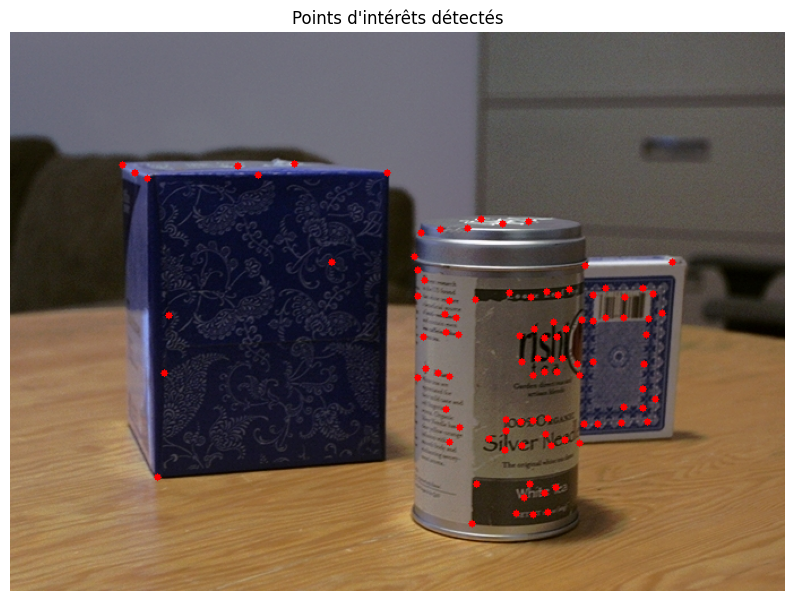

In [11]:
frames = load_frames('images')

# Choix de la première image pour détecter les points clés
frame = frames[0]

# Conversion en niveaux de gris
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Détecter les coins (points d'intérêts) avec goodFeaturesToTrack
corners = cv2.goodFeaturesToTrack(gray, maxCorners=100, qualityLevel=0.01, minDistance=10)
corners = np.int0(corners)

# Pour afficher les points en couleur, on garde l'image en BGR
frame_color = frame.copy()

# Tracer les points détectés
for corner in corners:
    x, y = corner.ravel()
    cv2.circle(frame_color, (x, y), 3, (0, 0, 255), -1)

# Affichage
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(frame_color, cv2.COLOR_BGR2RGB))
plt.title("Points d'intérêts détectés")
plt.axis("off")
plt.show()


Completer la fonction suivante qui implémente la méthode de Lucas-Kanade. 

In [18]:
def lucas_kanade(img1, img2, keypoints, window_size=5):
    """Estimate flow vector at each keypoint using Lucas-Kanade method.

    Args:
        img1 - Grayscale image of the current frame. Flow vectors are computed
            with respect to this frame.
        img2 - Grayscale image of the next frame.
        keypoints - Keypoints to track. Numpy array of shape (N, 2).
        window_size - Window size to determine the neighborhood of each keypoint.
            A window is centered around the current keypoint location.
            You may assume that window_size is always an odd number.
    Returns:
        flow_vectors - Estimated flow vectors for keypoints. flow_vectors[i] is
            the flow vector for keypoint[i]. Numpy array of shape (N, 2).

    Hints:
        - You may use np.linalg.inv to compute inverse matrix
    """
    assert window_size % 2 == 1, "window_size must be an odd number"

    flow_vectors = []
    w = window_size // 2

    # Compute partial derivatives
    Iy, Ix = np.gradient(img1)
    It = img2 - img1

    # For each [y, x] in keypoints, estimate flow vector [vy, vx]
    # using Lucas-Kanade method and append it to flow_vectors.
    for y, x in keypoints:
        # Keypoints can be located between integer pixels (subpixel locations).
        # For simplicity, we round the keypoint coordinates to nearest integer.
        # In order to achieve more accurate results, image brightness at subpixel
        # locations can be computed using bilinear interpolation.
        y, x = int(round(y)), int(round(x))

        ### YOUR CODE HERE
        Ix_win = Ix[y-w:y+w+1, x-w:x+w+1].flatten()
        Iy_win = Iy[y-w:y+w+1, x-w:x+w+1].flatten()
        It_win = It[y-w:y+w+1, x-w:x+w+1].flatten()

        A = np.vstack((Ix_win, Iy_win)).T
        b = -It_win


        ATA = A.T @ A
        if np.linalg.det(ATA) != 0:
            v = np.linalg.inv(ATA) @ (A.T @ b)
        else:
            v = np.array([0, 0])
        
        flow_vectors.append([v[1], v[0]])
        ### END YOUR CODE

    flow_vectors = np.array(flow_vectors)

    return flow_vectors

Tester maintenant votre fonction sur les deux premières frames.

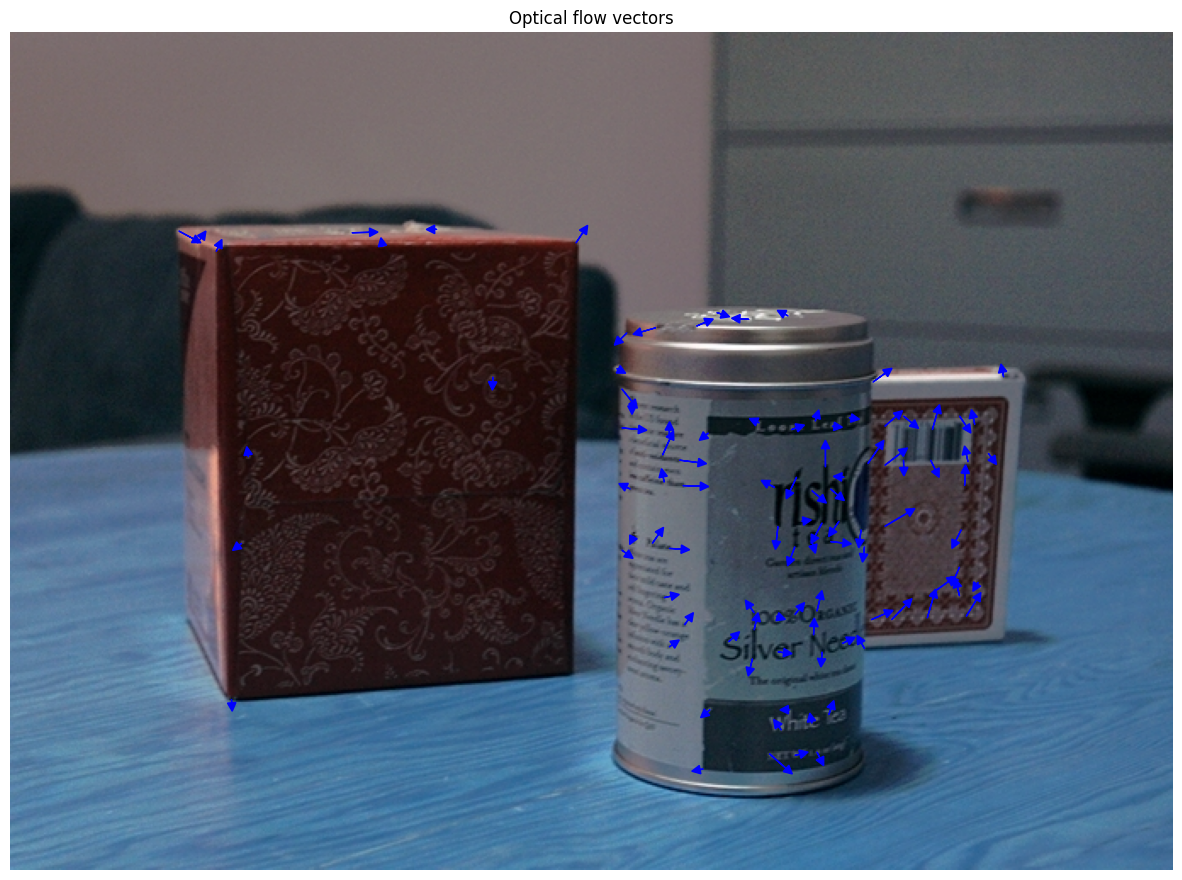

In [20]:
gray1 = cv2.cvtColor(frames[0], cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(frames[1], cv2.COLOR_BGR2GRAY)

corners = cv2.goodFeaturesToTrack(gray1, maxCorners=100, qualityLevel=0.01, minDistance=10)
keypoints = np.array([[int(round(c[0][1])), int(round(c[0][0]))] for c in corners])

flow_vectors = lucas_kanade(gray1, gray2, keypoints, window_size=5)


# Plot flow vectors sur la première image
plt.figure(figsize=(15,12))
plt.imshow(frames[0], cmap='gray')
plt.axis('off')
plt.title('Optical flow vectors')

# np.hstack((keypoints, flow_vectors)) crée une matrice de forme (N,4)
# Dans cette matrice, chaque ligne est organisée en [y, x, vy, vx]
for y, x, vy, vx in np.hstack((keypoints, flow_vectors)):
    plt.arrow(x, y, vx, vy, head_width=5, head_length=5, color='b')

plt.show()

Vous devriez avoir ce type de résultat

<center><img src='./Figs/optical_flow_vectors.png' width=400></center>

Nous pouvons estimer la position des points clés dans l'image suivante en ajoutant les vecteurs de flux aux points clés. Ecrivez le code permettant d'estimer et d'afficher la position des points clés dans l'image suivante.

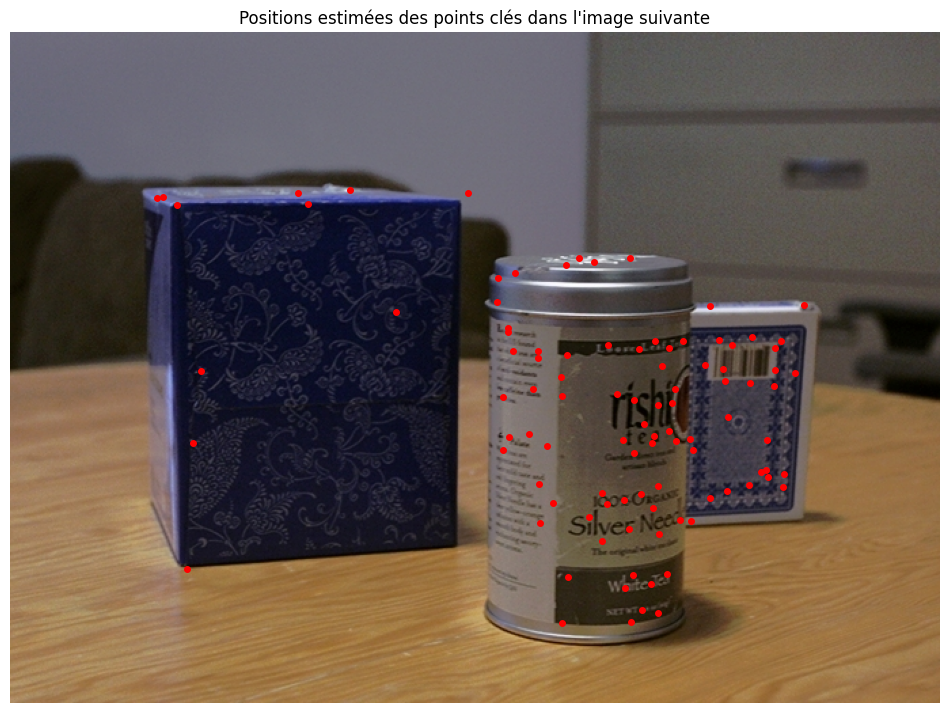

In [22]:
gray1 = cv2.cvtColor(frames[0], cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(frames[1], cv2.COLOR_BGR2GRAY)
corners = cv2.goodFeaturesToTrack(gray1, maxCorners=100, qualityLevel=0.01, minDistance=10)
keypoints = np.array([[int(round(c[0][1])), int(round(c[0][0]))] for c in corners]) 

flow_vectors = lucas_kanade(gray1, gray2, keypoints, window_size=5)
new_keypoints = keypoints + flow_vectors 

plt.figure(figsize=(12, 10))
plt.imshow(cv2.cvtColor(frames[1], cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Positions estimées des points clés dans l'image suivante")

for y, x in new_keypoints:
    plt.plot(x, y, 'ro', markersize=4)

plt.show()


## 1.4 Suivi des caractéristiques dans plusieurs images

Vous pouvez maintenant utiliser la méthode de Lucas-Kanade pour suivre les points clés sur plusieurs images. L'idée est simple : calculer les vecteurs de flux aux points clés de la $i$ème image, et ajouter les vecteurs de flux aux points pour suivre les points de la $i+1$ème image. 


La fonction `track_features` ci-dessous permet de mettre en place ce suivi.


In [ ]:
def track_features(
    frames,
    keypoints,
    error_thresh=1.5,
    optflow_fn=lucas_kanade,
    exclude_border=5,
    **kwargs
):

    """Track keypoints over multiple frames

    Args:
        frames - List of grayscale images with the same shape.
        keypoints - Keypoints in frames[0] to start tracking. Numpy array of
            shape (N, 2).
        error_thresh - Threshold to determine lost tracks.
        optflow_fn(img1, img2, keypoints, **kwargs) - Optical flow function.
        kwargs - keyword arguments for optflow_fn.

    Returns:
        trajs - A list containing tracked keypoints in each frame. trajs[i]
            is a numpy array of keypoints in frames[i]. The shape of trajs[i]
            is (Ni, 2), where Ni is number of tracked points in frames[i].
    """

    kp_curr = keypoints
    trajs = [kp_curr]
    patch_size = 3  # Take 3x3 patches to compute error
    w = patch_size // 2  # patch_size//2 around a pixel

    for i in range(len(frames) - 1):
        I = frames[i]
        J = frames[i + 1]
        #flow_vectors = optflow_fn(I, J, kp_curr, **kwargs)
        kp_next = kp_curr # + flow_vectors

        new_keypoints = []
        for yi, xi, yj, xj in np.hstack((kp_curr, kp_next)):
            # Declare a keypoint to be 'lost' IF:
            # 1. the keypoint falls outside the image J
            # 2. the error between points in I and J is larger than threshold

            yi = int(round(yi))
            xi = int(round(xi))
            yj = int(round(yj))
            xj = int(round(xj))
            # Point falls outside the image
            if (
                yj > J.shape[0] - exclude_border - 1
                or yj < exclude_border
                or xj > J.shape[1] - exclude_border - 1
                or xj < exclude_border
            ):
                continue

            # Compute error between patches in image I and J
            patchI = I[yi - w : yi + w + 1, xi - w : xi + w + 1]
            patchJ = J[yj - w : yj + w + 1, xj - w : xj + w + 1]
            error = compute_error(patchI, patchJ)
            if error > error_thresh:
                continue

            new_keypoints.append([yj, xj])

        kp_curr = np.array(new_keypoints)
        trajs.append(kp_curr)

    return trajs

Sans compléter pour le moment la fonction `compute_error`, compléter la partie du code ci-dessous consistant à extraire les points clés et exécuter le code.

In [ ]:
def compute_error(patch1, patch2):
    """Compute MSE between patch1 and patch2

        - Normalize patch1 and patch2 each to zero mean, unit variance
        - Compute mean square error between patch1 and patch2

    Args:
        patch1 - Grayscale image patch of shape (patch_size, patch_size)
        patch2 - Grayscale image patch of shape (patch_size, patch_size)
    Returns:
        error - Number representing mismatch between patch1 and patch2
    """
    assert patch1.shape == patch2.shape, "Different patch shapes"
    error = 0
    ### YOUR CODE HERE
    pass
    ### END YOUR CODE
    return error



def animated_scatter(frames, trajs, figsize=(10,8)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis('off')
    im = ax.imshow(frames[0])
    scat = ax.scatter(trajs[0][:,1], trajs[0][:,0],
                      facecolors='none', edgecolors='r')

    def animate(i):
        im.set_array(frames[i])
        if len(trajs[i]) > 0:
            scat.set_offsets(trajs[i][:,[1,0]])
        else: # If no trajs to draw
            scat.set_offsets([]) # clear the scatter plot

        return [im, scat,]

    ani = animation.FuncAnimation(fig, animate, frames=len(frames),
                                  interval=60, blit=True)

    return ani


# Detect keypoints to track in the first frame

# TO COMPLETE


trajs = track_features(frames, keypoints,
                       error_thresh=1.5,
                       optflow_fn=lucas_kanade,
                       window_size=5)
ani = animated_scatter(frames,trajs)
HTML(ani.to_html5_video())

**Que constatez-vous ?**  Vous devriez remarquer que certains des points s'éloignent et ne sont pas très bien suivis. Il ne faut donc pas garder ces mauvaises traces. Une façon simple de le faire est de comparer les patchs autour des points suivis dans deux images ultérieures. Si le patch autour d'un point n'est PAS similaire au patch autour du point correspondant dans l'image suivante, alors nous déclarons que le point est perdu. Ici, nous allons utiliser l'erreur quadratique moyenne entre deux patchs normalisés comme critère pour les pistes perdues.

**Complétez maintenant la fonction `compute_error` ci-dessus et exécutez à nouveau la cellule de code ci-dessous. Vous verrez que beaucoup de points disparaissent dans les images suivantes.**



# Partie 2 :  Approches de Lucas-Kanade avec représentation multi-résolution et itéraive 

Dans cette section, nous allons implémenter une version plus simple de la méthode décrite dans ["Pyramidal Implementation of the Lucas Kanade Feature Tracker"](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.185.585&rep=rep1&type=pdf).



## 2.1 Méthode itérative de Lucas-Kanade

Une des limitations de la méthode naïve de Lucas-Kanade est qu'elle ne peut pas suivre de grands mouvements entre les images. Afin de résoudre ce problème, nous pouvons affiner de manière itérative les vecteurs de flot optiques estimés. Voici la description étape par étape de l'algorithme :

Soit $p=\begin{bmatrix}p_x & p_y \end{bmatrix}^T$ un point sur l'image $I$. Le but est de trouver le vecteur de flux $v=\begin{bmatrix}v_x & v_y \end{bmatrix}^T$ tel que $p+v$ est le point correspondant de $p$ sur le cadre suivant $J$.

- Initialiser le vecteur flux :
$$
v=
\begin{bmatrix}
    0\\0
\end{bmatrix}
$$

- Calculez la matrice du gradient spatial :
$$
G=\sum_{x=p_x-w}^{p_x+w}\sum_{y=p_y-w}^{p_y+w}
\begin{bmatrix}
    I_{x}^2(x,y) & I_{x}(x,y)I_{y}(x,y)\\
    I_{x}(x,y)I_{y}(x,y) & I_{y}^2(x,y)
\end{bmatrix}
$$

- **pour $k=1$ à $K$**
    - Calcul de la différence temporelle : $\delta I_k(x, y) = I(x,y)-J(x+g_x+v_x, y+g_y+v_y)$.
    - Calculer le vecteur d'inadéquation d'image :

$$
b_k=\sum_{x=p_x-w}^{p_x+w}\sum_{y=p_y-w}^{p_y+w}
\begin{bmatrix}
    \delta I_k(x, y)I_x(x,y)\\
    \delta I_k(x, y)I_y(x,y)
\end{bmatrix}
$$
    - Calcul du flot optique: $v^k=G^{-1}b_k$
    - Mise à jour pour la prochaine itération: $v := v + v^k$


- Return $v$

Implémentez la méthode `iterative_lucas_kanade` ci-dessous.

In [ ]:
def iterative_lucas_kanade(img1, img2, keypoints, window_size=9, num_iters=7, g=None):
    """Estimate flow vector at each keypoint using iterative Lucas-Kanade method.

    Args:
        img1 - Grayscale image of the current frame. Flow vectors are computed
            with respect to this frame.
        img2 - Grayscale image of the next frame.
        keypoints - Keypoints to track. Numpy array of shape (N, 2).
        window_size - Window size to determine the neighborhood of each keypoint.
            A window is centered around the current keypoint location.
            You may assume that window_size is always an odd number.
        num_iters - Number of iterations to update flow vector.
        g - Flow vector guessed from previous pyramid level.
    Returns:
        flow_vectors - Estimated flow vectors for keypoints. flow_vectors[i] is
            the flow vector for keypoint[i]. Numpy array of shape (N, 2).
    """
    assert window_size % 2 == 1, "window_size must be an odd number"

    # Initialize g as zero vector if not provided
    if g is None:
        g = np.zeros(keypoints.shape)

    flow_vectors = []
    w = window_size // 2

    # Compute spatial gradients
    Iy, Ix = np.gradient(img1)

    for y, x, gy, gx in np.hstack((keypoints, g)):
        v = np.zeros(2)  # Initialize flow vector as zero vector
        y1 = int(round(y))
        x1 = int(round(x))

        # TODO: Compute inverse of G at point (x1, y1)
        ### YOUR CODE HERE
        pass
        ### END YOUR CODE

        # Iteratively update flow vector
        for k in range(num_iters):
            vx, vy = v
            # Refined position of the point in the next frame
            y2 = int(round(y + gy + vy))
            x2 = int(round(x + gx + vx))

            # TODO: Compute bk and vk = inv(G) x bk
            ### YOUR CODE HERE
            pass
            ### END YOUR CODE

            # Update flow vector by vk
            v += vk

        vx, vy = v
        flow_vectors.append([vy, vx])

    return np.array(flow_vectors)

Executer le code ci-dessous

In [ ]:
# Run iterative Lucas-Kanade method
flow_vectors = iterative_lucas_kanade(frames[0], frames[1], keypoints)

# Plot flow vectors
plt.figure(figsize=(15,12))
plt.imshow(frames[0])
plt.axis('off')
plt.title('Optical flow vectors (iterative LK)')

for y, x, vy, vx in np.hstack((keypoints, flow_vectors)):
    plt.arrow(x, y, vx, vy, head_width=5, head_length=5, color='b')

In [ ]:
# Plot tracked kepoints
new_keypoints = keypoints + flow_vectors
plt.figure(figsize=(15,12))
plt.imshow(frames[1])
plt.scatter(new_keypoints[:,1], new_keypoints[:,0],
            facecolors='none', edgecolors='r')
plt.axis('off')
plt.title('Tracked keypoints in the second frame (iterative LK)')
plt.show()

## 2.2 Flot optique grossier à fin
La méthode itérative ne peut toujours pas suivre les mouvements plus importants. Si nous réduisons l'échelle des images, les grands déplacements seront plus faciles à suivre. D'un autre côté, les mouvements plus petits deviennent plus difficiles à suivre car nous perdons des détails dans les images. Pour résoudre ce problème, nous pouvons représenter les images en multi-échelles, et calculer les vecteurs de flux de l'échelle grossière à l'échelle fine.

Votre premier travail consiste donc à construire une pyramide d'images. Pour cela, vous pouvez vous référer à cette [documentation](https://docs.opencv.org/3.4/d4/d1f/tutorial_pyramids.html).

In [ ]:
# TO COMPLETE

On considère maintenant l'algorithme multi-résolution de Lucas-Kanade :

Soit $p$ un point de l'image $I$ et $s$ l'échelle de la représentation.
- Construire la pyramide de $I$ et $J$: $\{I^L\}_{L=0,...,L_m}$ et $\{J^L\}_{L=0,...,L_m}$


- Initialisation : $g^{L_m}=
\begin{bmatrix}g_{x}^{L_m} & g_{y}^{L_m}\end{bmatrix}^T=\begin{bmatrix}0 & 0\end{bmatrix}^T$


- **for $L=L_m$ to $0$ with step of -1**

    - Calcul de la position de $p$ sur $I^L$: $p^L=p/s^L$
    
    - Soit $d^L$ le flot optique au niveau $L$:
$$
d^L := IterativeLucasKanade(I^L, J^L, p^L, g^L)
$$
    - Mise à jour pour le prochain niveau : $L-1$: $g^{L-1}=s(g^L+d^L)$
    
    
- Return $d=g^0+d^0$

Implementer la fonction `pyramid_lucas_kanade` ci-dessous.


In [ ]:
def pyramid_lucas_kanade(
    img1, img2, keypoints, window_size=9, num_iters=7, level=2, scale=2
):

    """Pyramidal Lucas Kanade method

    Args:
        img1 - same as lucas_kanade
        img2 - same as lucas_kanade
        keypoints - same as lucas_kanade
        window_size - same as lucas_kanade
        num_iters - number of iterations to run iterative LK method
        level - Max level in image pyramid. Original image is at level 0 of
            the pyramid.
        scale - scaling factor of image pyramid.

    Returns:
        d - final flow vectors
    """

    # Build image pyramids of img1 and img2
      ### YOUR CODE HERE
        
    # Initialize pyramidal guess
    g = np.zeros(keypoints.shape)

    for L in range(level, -1, -1):
        ### YOUR CODE HERE
        pass
        ### END YOUR CODE

    d = g + d
    return d

Executer le code ci-dessous

In [ ]:
# Lucas-Kanade method for optical flow
flow_vectors = pyramid_lucas_kanade(frames[0], frames[1], keypoints)

# Plot flow vectors
plt.figure(figsize=(15,12))
plt.imshow(frames[0])
plt.axis('off')
plt.title('Optical flow vectors (pyramid LK)')

for y, x, vy, vx in np.hstack((keypoints, flow_vectors)):
    plt.arrow(x, y, vx, vy, head_width=3, head_length=3, color='b')

In [ ]:
# Plot tracked kepoints
new_keypoints = keypoints + flow_vectors
plt.figure(figsize=(15,12))
plt.imshow(frames[1])
plt.scatter(new_keypoints[:,1], new_keypoints[:,0],
            facecolors='none', edgecolors='r')
plt.axis('off')
plt.title('Tracked keypoints in the second frame (pyramid LK)')

plt.show()

## 3. Suivi d'objet

Il s'agit de construire un système de suivi d'objets simple en utilisant la méthode Lucas-Kanade que nous avons implémentée dans les sections précédentes. 

Cette partie est laissée libre. Il faudra bien expliquer vos hypothèses de départ.